Số quan sát: 40
Train samples: 30
Test samples : 5
Huấn luyện LSTM hoàn tất
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

===== ĐÁNH GIÁ LSTM =====
MAE  = 12,541,306,440 USD
RMSE = 14,592,228,635 USD
R²   = 0.9020


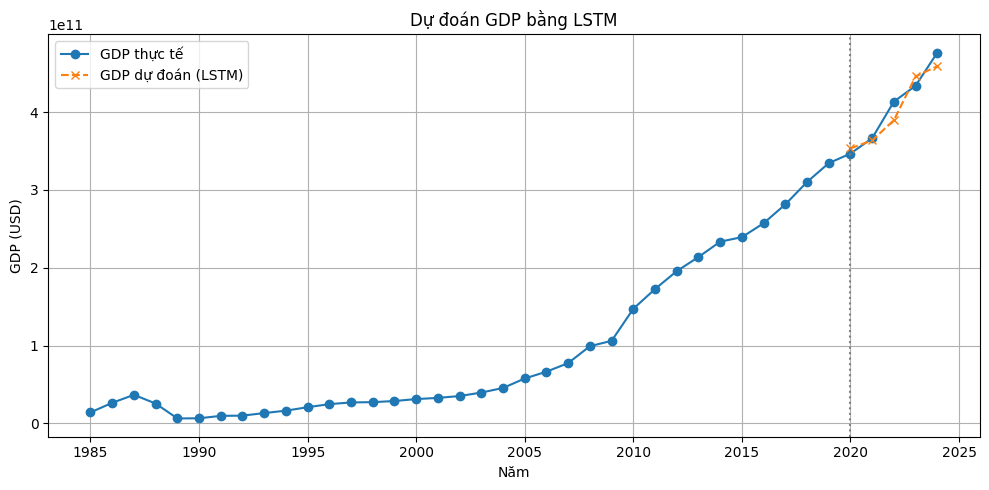

In [12]:
# ===== LSTM ĐƠN BIẾN DỰ ĐOÁN GDP =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

# 1. LOAD DATA
df = pd.read_csv("macro_vietnam_processed.csv")
df = df.sort_values("Year").reset_index(drop=True)

gdp = df["GDP"].values.reshape(-1, 1)
years = df["Year"].values

print("Số quan sát:", len(gdp))

# 2. SCALE GDP
scaler = MinMaxScaler()
gdp_scaled = scaler.fit_transform(gdp)

# 3. TẠO SEQUENCE (GIỐNG RNN)
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 5
X, y = create_sequences(gdp_scaled, window_size)

# 4. TRAIN / TEST SPLIT
n_test = 5

X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

years_test = years[window_size + len(X_train):]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

# 5. MÔ HÌNH LSTM (KHÁC RNN Ở ĐÂY)
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(32, activation="tanh"),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss="mse"
)

# 6. HUẤN LUYỆN
model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=4,
    verbose=0
)

print("Huấn luyện LSTM hoàn tất")

# 7. DỰ ĐOÁN & ĐÁNH GIÁ
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test)

mae  = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2   = r2_score(y_test_real, y_pred)

print("\n===== ĐÁNH GIÁ LSTM =====")
print(f"MAE  = {mae:,.0f} USD")
print(f"RMSE = {rmse:,.0f} USD")
print(f"R²   = {r2:.4f}")

# 8. BIỂU ĐỒ
plt.figure(figsize=(10,5))
plt.plot(years, gdp, label="GDP thực tế", marker="o")
plt.plot(years_test, y_pred, 
         label="GDP dự đoán (LSTM)", 
         marker="x", linestyle="--")
plt.axvline(years_test[0], color="gray", linestyle=":")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.title("Dự đoán GDP bằng LSTM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



===== KẾT QUẢ DỰ ĐOÁN GDP =====


,Year,GDP_Dự_đoán
0,2025,4.857133e+11
1,2026,5.062106e+11
2,2027,5.217204e+11
3,2028,5.548061e+11
4,2029,5.770698e+11
5,2030,5.917558e+11
6,2031,5.906606e+11
7,2032,5.952558e+11
8,2033,6.033798e+11
9,2034,6.149460e+11


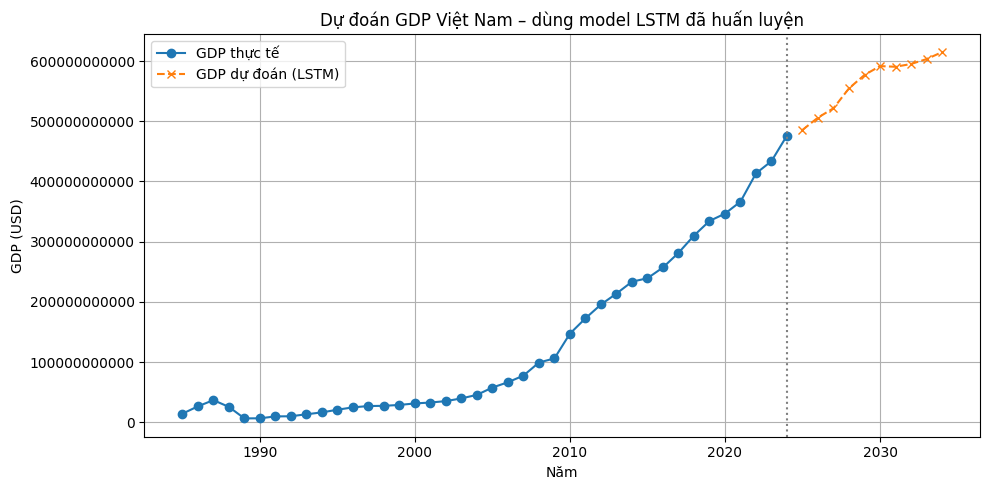

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. NHẬP SỐ NĂM MUỐN DỰ ĐOÁN
n_years = int(input("👉 Nhập số năm muốn dự đoán GDP: "))

# 2. LẤY CHUỖI CUỐI
last_seq = gdp_scaled[-window_size:]
predictions = []

# 3. DỰ ĐOÁN ITERATIVE
for _ in range(n_years):
    pred = model.predict(
        last_seq.reshape(1, window_size, 1),
        verbose=0
    )
    predictions.append(pred[0, 0])
    last_seq = np.append(last_seq[1:], pred)

# 4. INVERSE SCALE
predictions_real = scaler.inverse_transform(
    np.array(predictions).reshape(-1, 1)
)

future_years = np.arange(
    years[-1] + 1,
    years[-1] + 1 + n_years
)

# 5. BẢNG KẾT QUẢ
result_df = pd.DataFrame({
    "Year": future_years,
    "GDP_Dự_đoán": predictions_real.flatten()
})

print("\n===== KẾT QUẢ DỰ ĐOÁN GDP =====")
display(result_df)

# 6. BIỂU ĐỒ DEMO
plt.figure(figsize=(10,5))

plt.plot(years, gdp, label="GDP thực tế", marker="o")
plt.plot(future_years, predictions_real,
         label="GDP dự đoán (LSTM)",
         marker="x", linestyle="--")

plt.axvline(years[-1], color="gray", linestyle=":")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.title("Dự đoán GDP Việt Nam – dùng model LSTM đã huấn luyện")
plt.legend()
plt.grid(True)
plt.ticklabel_format(style="plain", axis="y")
plt.tight_layout()
plt.show()
